In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Base DataFrame & collision scaling

In [2]:
df = pd.read_csv('../raw_data/clean.csv').drop(columns = ['primary_road','weather_1','latitude','longitude','week_of_the_year','case_id'])
df['routes'] = df['routes'].apply(lambda x : x.upper())
df

,collision_severity,hour,day_of_the_week,routes
0,1,10,4,VENTURA FREEWAY
1,1,6,3,SAN DIEGO FREEWAY
2,3,6,3,VENTURA FREEWAY
3,2,6,3,VENTURA FREEWAY
4,1,14,3,RONALD REAGAN FREEWAY
...,...,...,...,...
718658,2,1,3,FOOTHILL FREEWAY
718659,2,16,0,HINDRY AVENUE
718660,5,1,6,CHAPMAN AVENUE
718661,1,4,0,POMONA FREEWAY


In [3]:
df.routes.value_counts()

SAN DIEGO FREEWAY         57132
SAN BERNARDINO FREEWAY    32490
FOOTHILL FREEWAY          29319
POMONA FREEWAY            29295
SANTA ANA FREEWAY         28144
                          ...  
RIDGE GATE                    1
LEO PLACE                     1
MAGELLAN DRIVE                1
WEST OLD MILL ROAD            1
REVA DRIVE                    1
Name: routes, Length: 21903, dtype: int64

### Scaling compris entre 1 et 31

In [4]:
def scaling(x):
    return 2**x - 1
    
df.collision_severity = df.collision_severity.apply(scaling)
df.collision_severity = df.collision_severity.apply(int)
df.head()

,collision_severity,hour,day_of_the_week,routes
0,1,10,4,VENTURA FREEWAY
1,1,6,3,SAN DIEGO FREEWAY
2,7,6,3,VENTURA FREEWAY
3,3,6,3,VENTURA FREEWAY
4,1,14,3,RONALD REAGAN FREEWAY


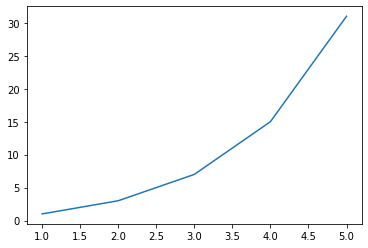

In [5]:
listi = np.arange(1,6,1)
scaled = scaling(listi)

plt.plot(listi,scaled);

# Dispatch roads of a trip into three lists, according to the scenario

#### scenario 1 : (road,hour,day) is in [existing_combinations]
#### scenario 2 : road not in [roads]
#### scenario 3 : if road in [roads], but no data for (hour,day)

In [6]:
def dispatch_roads(dictionary,dataframe,day,hour):
    """
    From a trip dictionary with roads as keys and distances as values,
    dispatches the roads into 3 list according to the scenario
    """
    list_road_day_hour = []
    list_no_road = []
    list_no_day_hour = []
    
    for key,value in dictionary.items():
        
        if key.upper() not in dataframe['routes'].unique():
            list_no_road.append(key.upper())
            
        elif len(dataframe[(dataframe['routes'] == key.upper()) \
                           & (dataframe['day_of_the_week'] == day) & (dataframe['hour'] == hour)]) == 0:
            list_no_day_hour.append(key.upper())
            
        else:
            list_road_day_hour.append(key.upper())

    return list_road_day_hour, list_no_road, list_no_day_hour

In [7]:
dict_test = {'Ventura Freeway':200,'Ronald Reagan Freeway':500,'Boulevard richard LENOIR':450,\
               'Hindry Avenue':1300,'Dunnet Avenue':20,'Chapman Avenue':180,'Rue de la sante':370}

list_road_day_hour, list_no_road, list_no_day_hour = dispatch_roads(dict_test,df,5,17)
print(list_road_day_hour)
print(list_no_road)
print(list_no_day_hour)

['VENTURA FREEWAY', 'RONALD REAGAN FREEWAY']
['BOULEVARD RICHARD LENOIR', 'RUE DE LA SANTE']
['HINDRY AVENUE', 'DUNNET AVENUE', 'CHAPMAN AVENUE']


# if (road,day,hour) is in [existing_combinations]:

#### i.e. si on a de la data pour ce tuple en question

In [8]:
def road_day_hour(dataframe,list_roads,day,hour):
    """
    For tuples of (roads,day,hour) we have data on
    Returns a dictionnary with roads as keys 
    and collision severity estimates as values
    """
    dict_predict = {}
    
    for road in list_roads:
        inter = dataframe[(dataframe['routes'] == road) \
                                    & (dataframe['day_of_the_week'] == day) \
                                    & (dataframe['hour'] == hour)]
        result = inter['collision_severity'].mean()
        dict_predict[road] = result
        
    return dict_predict

In [9]:
dict_1 = road_day_hour(df,list_road_day_hour,0,7)
dict_1

{'VENTURA FREEWAY': 2.169398907103825,
 'RONALD REAGAN FREEWAY': 2.5531914893617023}

# if road not in [roads]

#### i.e. si la route renvoyée par l'API est inconnue

In [10]:
def road_not_in_roads(dataframe,list_roads,day,hour):
    """
    For roads don't have
    Returns a dictionnary with roads as keys 
    and collision severity estimates as values
    """
    dict_predict = {}
    
    inter = dataframe[(dataframe['day_of_the_week'] == day) \
                      & (dataframe['hour'] == hour)]
    result = inter['collision_severity'].mean()
    
    for road in list_roads:
        dict_predict[road] = result
        
    return dict_predict

In [11]:
dict_2 = road_not_in_roads(df,list_no_road,0,7)
dict_2

{'BOULEVARD RICHARD LENOIR': 2.105657237936772,
 'RUE DE LA SANTE': 2.105657237936772}

# if road in [roads]

#### i.e. si on a la route, mais pas de donnée pour le tuple (heure,jour)

In [12]:
def no_day_hour(dataframe,list_roads,day,hour):
    """
    For roads we have, for which we don't have data on that date/hour
    Returns a dictionnary with roads as keys 
    and collision severity estimates as values
    """
    inter = dataframe[dataframe['routes'].isin(list_roads)].copy()

    X = inter.drop(columns = ['collision_severity'])
    y = inter[['collision_severity']]

    pipe = make_pipeline(
        OneHotEncoder(sparse = False),
        LinearRegression()
    )

    pipe.fit(X, y)
    
    dict_predict = {}
    
    for road in list_roads:
        X_pred = [[hour,day,road]]
        result = pipe.predict(X_pred)
        dict_predict[road] = result[0][0]

    return dict_predict

In [13]:
dict_3 = no_day_hour(df,list_no_day_hour,0,7)
dict_3

{'HINDRY AVENUE': 3.1875, 'DUNNET AVENUE': 2.875, 'CHAPMAN AVENUE': 2.1875}

# Concat 3 dictionaries

In [14]:
def concat_3_dict(d1,d2,d3):
    """
    Concatenates 3 dictionaries
    """
    d4 = d1.copy()
    d4.update(d2)
    d4.update(d3)
    return d4

In [15]:
dict_concat = concat_3_dict(dict_1,dict_2,dict_3)
dict_concat

{'VENTURA FREEWAY': 2.169398907103825,
 'RONALD REAGAN FREEWAY': 2.5531914893617023,
 'BOULEVARD RICHARD LENOIR': 2.105657237936772,
 'RUE DE LA SANTE': 2.105657237936772,
 'HINDRY AVENUE': 3.1875,
 'DUNNET AVENUE': 2.875,
 'CHAPMAN AVENUE': 2.1875}

# Compute ponderated mean

#### i.e. mean collision_severity ponderated by distance 

In [20]:
def ponderated_mean(d1,d2):
    """
    Takes two dictionaries in argument :
    the first one has roads in keys and distance in values,
    the second one has roads in keys and collision_severity in values.
    Computes the mean of collision_severities ponderated with distances
    """
    mean_danger = 0
    sum_dist = 0
    
    for key,value in d1.items():
        mean_danger += d2[key.upper()] * value
        sum_dist += value
        
    mean_danger = mean_danger/sum_dist
    
    return mean_danger

In [21]:
result_de_la_mort_qui_tue = ponderated_mean(dict_test,dict_concat)
result_de_la_mort_qui_tue

2.65964055006946